## Load dataset

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization,GlobalAveragePooling2D
# 1d-textual data(sequential), 2d-images(non-sequential data), 3d-videos
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## Data preprocessing

In [4]:
BASE_DIR="/kaggle/input/melanoma-cancer-dataset"
TRAIN_DIR=os.path.join(BASE_DIR,'train')
TEST_DIR=os.path.join(BASE_DIR,'test')

# Image size and batch size
IMG_SIZE=(224,224)
BATCH_SIZE=32

#Data Augmentation for training
train_datagen=ImageDataGenerator(
    rescale=1./255, #rescale data to fit inside a predetermined range
    rotation_range=20, #rotates img on random angle
    width_shift_range=20, #how much we can shift img by width
    height_shift_range=20, #same for height
    shear_range=0.2, #we fix one axis and stretch the image at a certain angle known as the shear angle. 
    zoom_range=0.2,
    horizontal_flip=True
)
# Only Rescaling for testing
test_datagen=ImageDataGenerator(
    rescale=1./255
)

# Load training data
train_generator=train_datagen.flow_from_directory(
    directory=TRAIN_DIR,
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE,
    class_mode='binary'
)
# Load test data
test_generator=test_datagen.flow_from_directory(
    directory=TEST_DIR,
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE,
    class_mode='binary'
)

# Print class labels
print('Class mapping:',train_generator.class_indices)

Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Class mapping: {'Benign': 0, 'Malignant': 1}


## EDA

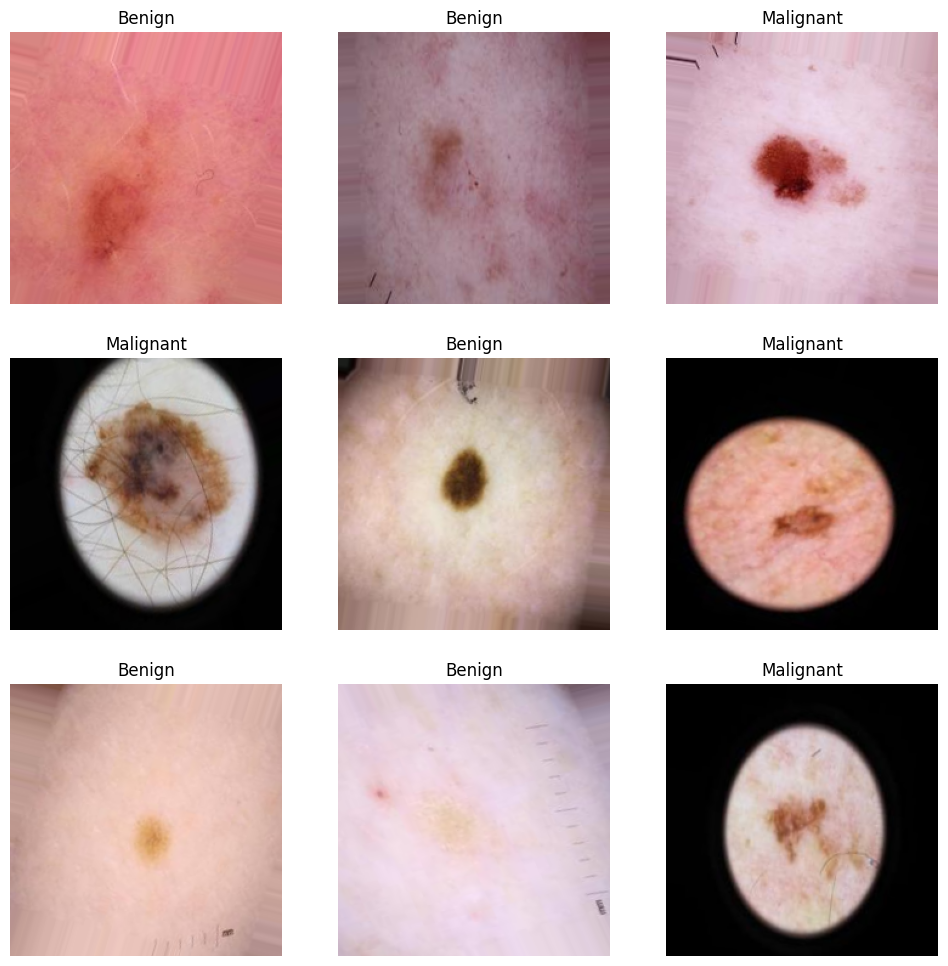

In [5]:
images,labels=next(train_generator)
plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(3,3,1+i)
    plt.imshow(images[i])
    plt.title('Benign' if labels[i]==0 else 'Malignant')
    plt.axis('off')
plt.show()

## Build CNN Model

In [6]:
model = Sequential([
    # 1st convolution layer: units,stride size,if img=relu
    Conv2D(128,(3,3),activation='relu',input_shape=(224,224,3)),
    MaxPooling2D((2,2)),
    # 2nd convolution layer
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    # 3rd convolution layer
    Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)),
    MaxPooling2D((2,2)),
    # classification
    Flatten(),
    # fully connected
    Dense(512,activation='relu'),
    Dropout(0.5),
    # if binary=sigmoid, multiple=softmax
    Dense(1,activation='sigmoid')
])

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      11,076,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,172,449 (42.62 MB)

 Trainable params: 11,172,449 (42.62 MB)

 Non-trainable params: 0 (0.00 B)

## Train and Evaluate Model

In [7]:
early_stopping=EarlyStopping(
    monitor='val_loss', # if validation loss doesn't improve
    patience=5, # after 5 epochs, then stop
    restore_best_weights=True,# load best weights
    verbose=1
)
lr_schedule=ReduceLROnPlateau(
    monitor='val_loss',
    patience=3, # Reduce lr after 3 epochs if val loss doesn't improve
    factor=0.3,
    min_learning=1e-7, # reduce if result doesn't improve
    verbose=1

)
history=model.fit(train_generator, 
                  steps_per_epoch=train_generator.samples//BATCH_SIZE,
                  epochs=30,
                  validation_data=test_generator,
                  validation_steps=test_generator.samples//BATCH_SIZE,
                  # if model not improving then stop it
                  callbacks=[early_stopping,lr_schedule])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


371/371 ━━━━━━━━━━━━━━━━━━━━ 199s 508ms/step - accuracy: 0.6850 - loss: 0.5749 - val_accuracy: 0.7324 - val_loss: 0.5089 - learning_rate: 0.0010
Epoch 2/30
  1/371 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.8750 - loss: 0.3591

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


371/371 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8750 - loss: 0.3591 - val_accuracy: 0.8125 - val_loss: 0.4688 - learning_rate: 0.0010
Epoch 3/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 131s 345ms/step - accuracy: 0.8118 - loss: 0.4125 - val_accuracy: 0.7354 - val_loss: 0.4857 - learning_rate: 0.0010
Epoch 4/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - accuracy: 0.8125 - loss: 0.4627 - val_accuracy: 0.8750 - val_loss: 0.3903 - learning_rate: 0.0010
Epoch 5/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 130s 344ms/step - accuracy: 0.8312 - loss: 0.3874 - val_accuracy: 0.8311 - val_loss: 0.3840 - learning_rate: 0.0010
Epoch 6/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 71us/step - accuracy: 0.7812 - loss: 0.3815 - val_accuracy: 0.7500 - val_loss: 0.4686 - learning_rate: 0.0010
Epoch 7/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 128s 340ms/step - accuracy: 0.8426 - loss: 0.3718 - val_accuracy: 0.8574 - val_loss: 0.3913 - learning_rate: 0.0010
Epoch 8/30
  1/371 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.9375 - loss: 0.2

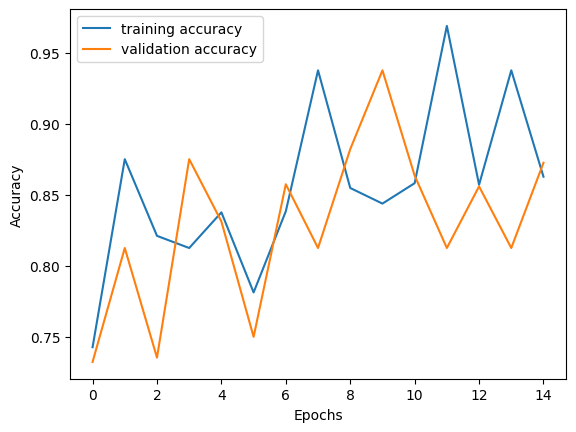

In [13]:
# Save model
model.save('skin_cancer_model.h5')

# Plot Training history
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step
              precision    recall  f1-score   support

           0       0.50      0.49      0.50      1000
           1       0.49      0.50      0.49       984

    accuracy                           0.50      1984
   macro avg       0.50      0.50      0.50      1984
weighted avg       0.50      0.50      0.50      1984



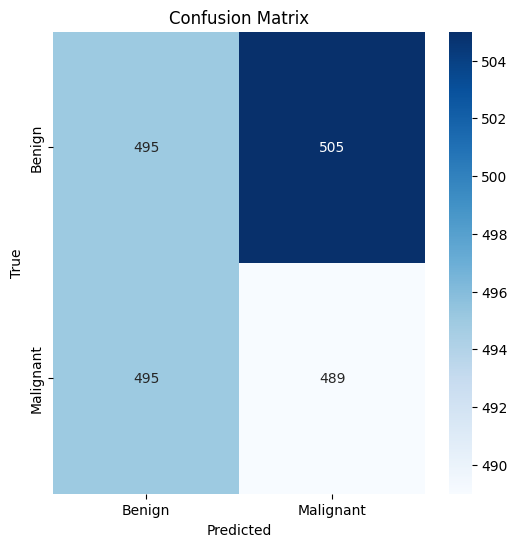

In [9]:
# Predict model
test_pred=model.predict(test_generator,steps=test_generator.samples//BATCH_SIZE,verbose=1)
test_pred_labels=(test_pred>0.5).astype('int32')
#test_pred_labels
test_true_labels=test_generator.classes[:len(test_pred_labels)]
#test_true_label
print(classification_report(test_true_labels,test_pred_labels))

# Confusion Matrix
cm = confusion_matrix(test_true_labels, test_pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Prediction system

In [10]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the entire model
model = load_model('/kaggle/working/skin_cancer_model.h5')


def predict_skin_cancer(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))  # Load Image
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make Prediction
    prediction = model.predict(img_array)
    class_label = "Malignant" if prediction > 0.5 else "Benign"
    
    # Show Image with Prediction
    plt.imshow(img)
    plt.title(f"Predicted: {class_label}")
    plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step


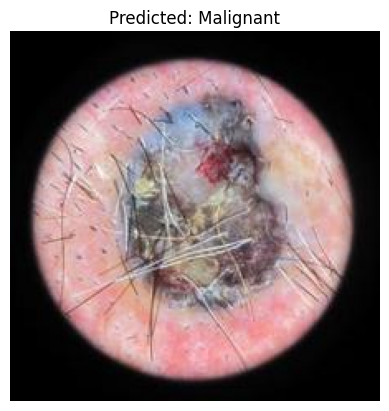

In [11]:
# Test on new image
predict_skin_cancer("/kaggle/input/melanoma-cancer-dataset/test/Malignant/5616.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


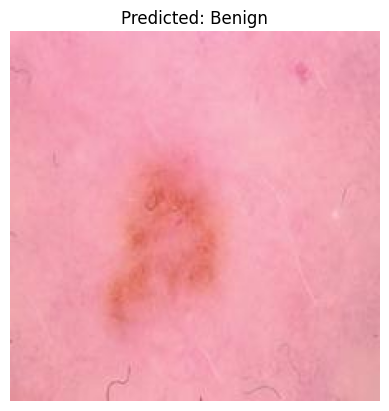

In [12]:
# Test on new image
predict_skin_cancer("/kaggle/input/melanoma-cancer-dataset/train/Benign/1004.jpg", model)